# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Step 01: Load the data

In [ ]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [ ]:
# Display the first few rows of each dataframe
print("Portfolio:")
print(portfolio.head())
print("\nProfile:")
print(profile.head())
print("\nTranscript:")
print(transcript.head())

# Step 02: Understand and clean the data

In [3]:
#Porfolio data

print(portfolio.info())
print(portfolio.describe())
print(portfolio.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes
None
       difficulty   duration     reward
count   10.000000  10.000000  10.000000
mean     7.700000   6.500000   4.200000
std      5.831905   2.321398   3.583915
min      0.000000   3.000000   0.000000
25%      5.000000   5.000000   2.000000
50%      8.500000   7.000000   4.000000
75%     10.000000   7.000000   5.000000
max     20.000000  10.000000  10.000000
channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64


In [4]:
portfolio['offer_type'].describe()

count       10
unique       3
top       bogo
freq         4
Name: offer_type, dtype: object

In [5]:
#Profile data
print(profile.info())
print(profile.describe())
print(profile.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB
None
                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000
age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [6]:
# Handling missing values
# Replace missing gender values with 'Unknown'
profile['gender'].fillna('Unknown', inplace=True)

# Replace missing income values with the median income
profile['income'].fillna(profile['income'].median(), inplace=True)

# Replace missing age values with the median age
profile['age'].replace(118, np.nan, inplace=True)
profile['age'].fillna(profile['age'].median(), inplace=True)

In [7]:
#Profile data
print(profile.info())
print(profile.describe())
print(profile.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null float64
became_member_on    17000 non-null int64
gender              17000 non-null object
id                  17000 non-null object
income              17000 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 664.1+ KB
None
                age  became_member_on         income
count  17000.000000      1.700000e+04   17000.000000
mean      54.471118      2.016703e+07   65225.235294
std       16.234809      1.167750e+04   20174.747749
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   51000.000000
50%       55.000000      2.017080e+07   64000.000000
75%       65.000000      2.017123e+07   76000.000000
max      101.000000      2.018073e+07  120000.000000
age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64


In [8]:
#Transcript datapr
print(transcript.head())
print(transcript.info())
print(transcript.describe())
print(transcript.isnull().sum())

            event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None
             

# Step 03 : Merge the datasets

In [9]:
#First, we expand the 'value' column in the transcript dataset
print('First, we expand the ''value'' column in the transcript dataset')
transcript = pd.concat([transcript.drop(['value'], axis=1), transcript['value'].apply(pd.Series)], axis=1)

# Create dummy variables for offer_type in the portfolio DataFrame
portfolio = pd.get_dummies(portfolio, columns=['offer_type'])

# Merge the transcript and profile datasets
print('then we merge the transcript and profile datasets')
data = transcript.merge(profile, left_on='person', right_on='id', how='left')

# Merge the resulting dataframe with the portfolio dataset
print('and merge the resulting dataframe with the portfolio dataset')
data = data.merge(portfolio, left_on='offer_id', right_on='id', how='left')


First, we expand the value column in the transcript dataset
then we merge the transcript and profile datasets
and merge the resulting dataframe with the portfolio dataset


In [10]:
# Check the changes
print(data.head())
print(data.info())
print(data.isnull().sum())

            event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                           offer id  amount offer_id  reward_x   age  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN      NaN       NaN  75.0   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN      NaN       NaN  55.0   
2  2906b810c7d4411798c6938adc9daaa5     NaN      NaN       NaN  68.0   
3  fafdcd668e3743c1bb461111dcafc2a4     NaN      NaN       NaN  55.0   
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN      NaN       NaN  55.0   

   became_member_on   gender                              id_x    income  \
0          20170509        F  78afa995795e4d85b5d9ceeca43f5fef  100000.0   
1          20170804  Unknown  a03223e636434f42ac

# Step 04 : Feature Engineering

In [11]:
# Convert 'became_member_on' to datetime
print('Converting ''became_member_on'' to datetime')
data['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# Calculate the date of the event
print('Calculating the date of the event')
data['event_time'] = pd.to_datetime(data['time'], unit='h', origin='2018-01-01')

# Calculate the maximum event time in the dataset
print('Calculating the maximum event time in the dataset')
max_event_time = data['event_time'].max()

# Create a new feature 'membership_duration' in days
print('Creating a new feature ''membership_duration'' in days')
data['membership_duration'] = (max_event_time - data['became_member_on']).dt.days

# Check if the necessary columns are present
print('Checking if the necessary columns are present')
print(data.columns)









Converting became_member_on to datetime
Calculating the date of the event
Calculating the maximum event time in the dataset
Creating a new feature membership_duration in days
Checking if the necessary columns are present
Index(['event', 'person', 'time', 'offer id', 'amount', 'offer_id', 'reward_x',
       'age', 'became_member_on', 'gender', 'id_x', 'income', 'channels',
       'difficulty', 'duration', 'id_y', 'reward_y', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'event_time',
       'membership_duration'],
      dtype='object')


In [12]:
# Check the changes
print(data.head())
print(data.info())
print(data.isnull().sum())

            event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                           offer id  amount offer_id  reward_x   age  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN      NaN       NaN  75.0   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN      NaN       NaN  55.0   
2  2906b810c7d4411798c6938adc9daaa5     NaN      NaN       NaN  68.0   
3  fafdcd668e3743c1bb461111dcafc2a4     NaN      NaN       NaN  55.0   
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN      NaN       NaN  55.0   

  became_member_on   gender         ...          channels  difficulty  \
0       2017-02-12        F         ...               NaN         NaN   
1       2017-07-15  Unknown         ...               

In [13]:
# Handle NaN values in 'channels' column
print('Handling NaN values in ''channels'' column')
data['channels'] = data['channels'].apply(lambda x: x if isinstance(x, list) else [])


# Create dummy variables for categorical features
print('Creating dummy variables for categorical features')
data = pd.get_dummies(data, columns=['gender'], drop_first=True)

# Expand 'channels' into dummy variables
print('Expanding ''channels'' into dummy variables')
channels_dummies = data['channels'].apply(lambda x: pd.Series(1, index=x)).fillna(0).astype(int)
data = pd.concat([data.drop('channels', axis=1), channels_dummies], axis=1)

# Handle the 'event' column to create response variables
print('Handling the ''event''column to create response variables')
data['offer_received'] = (data['event'] == 'offer received').astype(int)
data['offer_viewed'] = (data['event'] == 'offer viewed').astype(int)
data['offer_completed'] = (data['event'] == 'offer completed').astype(int)



# Handle missing values in 'offer_id' by filling with a placeholder
print('Handling missing values in ''offer_id'' by filling with a placeholder')
data['offer_id'].fillna('no_offer', inplace=True)







Handling NaN values in channels column
Creating dummy variables for categorical features
Expanding channels into dummy variables
Handling the eventcolumn to create response variables
Handling missing values in offer_id by filling with a placeholder


In [14]:
# Check the changes
print(data.head())
print(data.info())
print(data.isnull().sum())

            event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                           offer id  amount  offer_id  reward_x   age  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN  no_offer       NaN  75.0   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN  no_offer       NaN  55.0   
2  2906b810c7d4411798c6938adc9daaa5     NaN  no_offer       NaN  68.0   
3  fafdcd668e3743c1bb461111dcafc2a4     NaN  no_offer       NaN  55.0   
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN  no_offer       NaN  55.0   

  became_member_on                              id_x       ...         \
0       2017-02-12  78afa995795e4d85b5d9ceeca43f5fef       ...          
1       2017-07-15  a03223e636434f42ac4c3df47e8b

In [15]:
# Drop unnecessary columns
print('Dropping unnecessary columns')
data.drop(['id_x', 'id_y', 'person', 'event', 'time', 'became_member_on','offer id', 'event_time'], axis=1, inplace=True)


Dropping unnecessary columns


In [16]:
# Check the changes
print(data.head())
print(data.info())
print(data.isnull().sum())

   amount  offer_id  reward_x   age    income  difficulty  duration  reward_y  \
0     NaN  no_offer       NaN  75.0  100000.0         NaN       NaN       NaN   
1     NaN  no_offer       NaN  55.0   64000.0         NaN       NaN       NaN   
2     NaN  no_offer       NaN  68.0   70000.0         NaN       NaN       NaN   
3     NaN  no_offer       NaN  55.0   64000.0         NaN       NaN       NaN   
4     NaN  no_offer       NaN  55.0   64000.0         NaN       NaN       NaN   

   offer_type_bogo  offer_type_discount       ...         gender_M  gender_O  \
0              NaN                  NaN       ...                0         0   
1              NaN                  NaN       ...                0         0   
2              NaN                  NaN       ...                1         0   
3              NaN                  NaN       ...                0         0   
4              NaN                  NaN       ...                0         0   

   gender_Unknown  web  email  m

In [17]:
# Handle missing values
print('Handling missing values')
data.fillna(data.median(), inplace=True)


Handling missing values


In [18]:
# Create a temporary 'offer_type' column for EDA purposes
print('Creating a temporary ''offer_type'' column for EDA purposes')
# Create a new 'offer_type' column for visualization
data['offer_type'] = np.where(data['offer_type_discount'] == 1, 'discount',
                                    np.where(data['offer_type_informational'] == 1, 'informational',
                                             np.where(data['offer_type_bogo'] == 1, 'bogo', 'other')))

Creating a temporary offer_type column for EDA purposes


In [19]:
print(data['offer_type'].unique())


['discount' 'bogo']


In [20]:
# Check the changes
print(data.head())
print(data.info())
print(data.isnull().sum())

   amount  offer_id  reward_x   age    income  difficulty  duration  reward_y  \
0    8.89  no_offer       5.0  75.0  100000.0        10.0       7.0       5.0   
1    8.89  no_offer       5.0  55.0   64000.0        10.0       7.0       5.0   
2    8.89  no_offer       5.0  68.0   70000.0        10.0       7.0       5.0   
3    8.89  no_offer       5.0  55.0   64000.0        10.0       7.0       5.0   
4    8.89  no_offer       5.0  55.0   64000.0        10.0       7.0       5.0   

   offer_type_bogo  offer_type_discount     ...      gender_O  gender_Unknown  \
0              0.0                  1.0     ...             0               0   
1              0.0                  1.0     ...             0               1   
2              0.0                  1.0     ...             0               0   
3              0.0                  1.0     ...             0               1   
4              0.0                  1.0     ...             0               1   

   web  email  mobile  soc

In [21]:
# Check the changes
print(data.head())
print(data.info())
print(data.isnull().sum())

   amount  offer_id  reward_x   age    income  difficulty  duration  reward_y  \
0    8.89  no_offer       5.0  75.0  100000.0        10.0       7.0       5.0   
1    8.89  no_offer       5.0  55.0   64000.0        10.0       7.0       5.0   
2    8.89  no_offer       5.0  68.0   70000.0        10.0       7.0       5.0   
3    8.89  no_offer       5.0  55.0   64000.0        10.0       7.0       5.0   
4    8.89  no_offer       5.0  55.0   64000.0        10.0       7.0       5.0   

   offer_type_bogo  offer_type_discount     ...      gender_O  gender_Unknown  \
0              0.0                  1.0     ...             0               0   
1              0.0                  1.0     ...             0               1   
2              0.0                  1.0     ...             0               0   
3              0.0                  1.0     ...             0               1   
4              0.0                  1.0     ...             0               1   

   web  email  mobile  soc

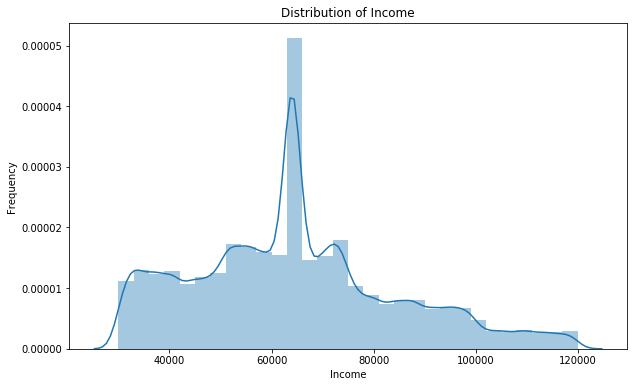

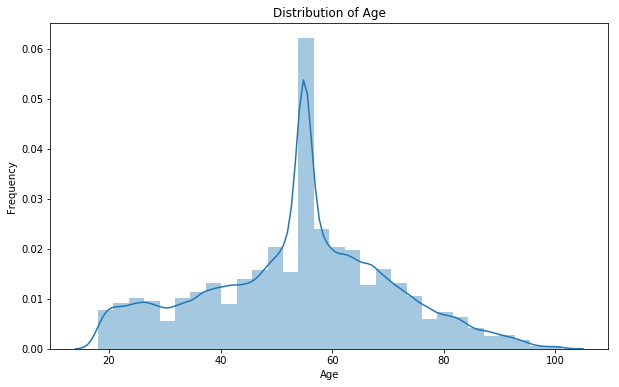

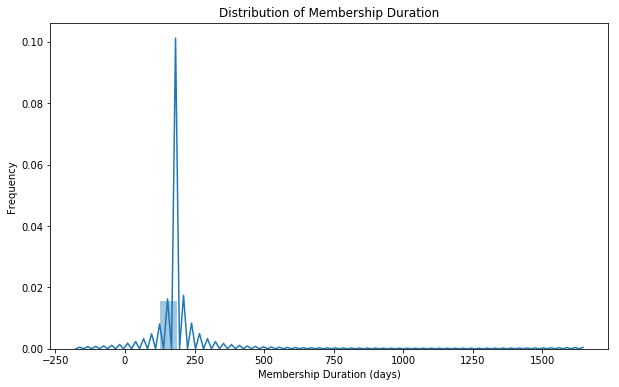

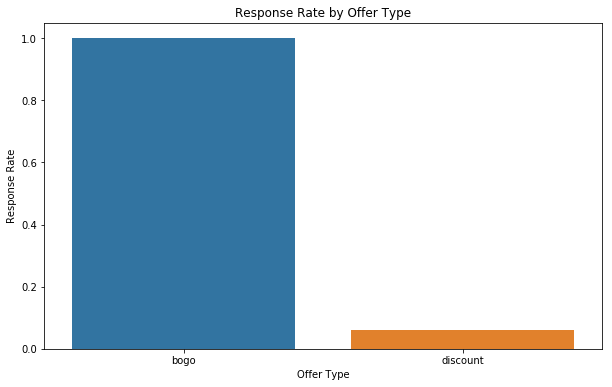

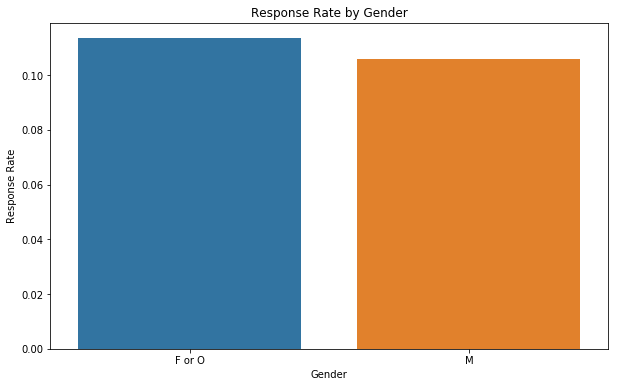

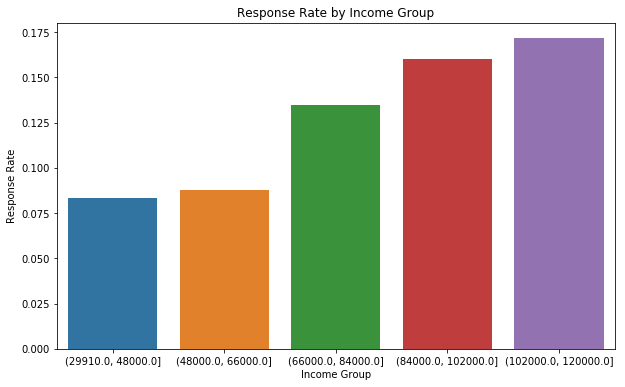

In [22]:


# Distribution of income
plt.figure(figsize=(10, 6))
sns.distplot(data['income'].dropna(), bins=30, kde=True)
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

# Distribution of age
plt.figure(figsize=(10, 6))
sns.distplot(data['age'].dropna(), bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Membership duration
plt.figure(figsize=(10, 6))
sns.distplot(data['membership_duration'].dropna(), bins=30, kde=True)
plt.title('Distribution of Membership Duration')
plt.xlabel('Membership Duration (days)')
plt.ylabel('Frequency')
plt.show()

# Response rate by offer type
plt.figure(figsize=(10, 6))
response_rate = data.groupby('offer_type')['offer_completed'].mean().reset_index()
sns.barplot(x='offer_type', y='offer_completed', data=response_rate)
plt.title('Response Rate by Offer Type')
plt.xlabel('Offer Type')
plt.ylabel('Response Rate')
plt.show()

# Response rate by gender
plt.figure(figsize=(10, 6))
response_rate_gender = data.groupby('gender_M')['offer_completed'].mean().reset_index()
response_rate_gender.columns = ['gender', 'response']
response_rate_gender['gender'] = response_rate_gender['gender'].replace({1: 'M', 0: 'F or O'})
sns.barplot(x='gender', y='response', data=response_rate_gender)
plt.title('Response Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Response Rate')
plt.show()


# Response rate by income group
plt.figure(figsize=(10, 6))
data['income_group'] = pd.cut(data['income'], bins=5)
response_rate_income = data.groupby('income_group')['offer_completed'].mean().reset_index()
sns.barplot(x='income_group', y='offer_completed', data=response_rate_income)
plt.title('Response Rate by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Response Rate')
plt.show()


In [23]:
# Drop the dummy columns for 'offer_type' after creating the combined column
data.drop(['offer_type_discount', 'offer_type_informational', 'offer_type_bogo'], axis=1, inplace=True)

In [24]:
# Convert 'offer_type' to numerical using one-hot encoding
data = pd.get_dummies(data, columns=['offer_type','income_group'], drop_first=True)

# Verify the data types again
print(data.dtypes)

amount                               float64
offer_id                              object
reward_x                             float64
age                                  float64
income                               float64
difficulty                           float64
duration                             float64
reward_y                             float64
membership_duration                  float64
gender_M                               uint8
gender_O                               uint8
gender_Unknown                         uint8
web                                    int64
email                                  int64
mobile                                 int64
social                                 int64
offer_received                         int64
offer_viewed                           int64
offer_completed                        int64
offer_type_discount                    uint8
income_group_(48000.0, 66000.0]        uint8
income_group_(66000.0, 84000.0]        uint8
income_gro

# Split data set into Train -Test

In [25]:
# Select features and target variable
features = ['age', 'income', 'membership_duration', 'offer_received', 'offer_viewed'] + \
           [col for col in data.columns if 'gender_' in col] + \
           [col for col in data.columns if 'offer_type_' in col] + \
           [col for col in data.columns if col in ['email', 'mobile', 'social', 'web']]

X = data[features]
y = data['offer_completed']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





# Train the model

In [26]:
# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


# Evaluate the Model

In [27]:
# Evaluate the model
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
train_precision = precision_score(y_train, y_pred_train)
test_precision = precision_score(y_test, y_pred_test)
train_recall = recall_score(y_train, y_pred_train)
test_recall = recall_score(y_test, y_pred_test)
train_f1 = f1_score(y_train, y_pred_train)
test_f1 = f1_score(y_test, y_pred_test)

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Train Precision: {train_precision}')
print(f'Test Precision: {test_precision}')
print(f'Train Recall: {train_recall}')
print(f'Test Recall: {test_recall}')
print(f'Train F1 Score: {train_f1}')
print(f'Test F1 Score: {test_f1}')


Train Accuracy: 1.0
Test Accuracy: 1.0
Train Precision: 1.0
Test Precision: 1.0
Train Recall: 1.0
Test Recall: 1.0
Train F1 Score: 1.0
Test F1 Score: 1.0


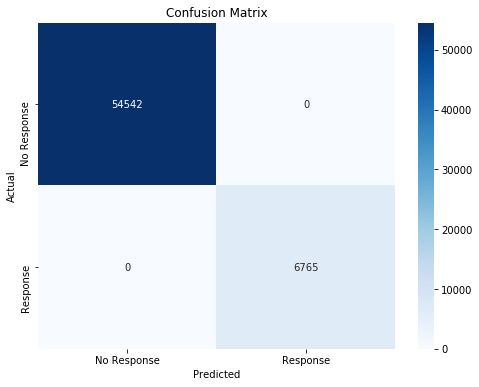

In [28]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Response', 'Response'], yticklabels=['No Response', 'Response'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Further evaluation